# Supply and Demand for Elspot

NordPool has provided the following information on the Elspot System Price bid curves. The document below describes how to adjust the buy and sell volumes using accepted blocks buy/sell and net flows.

In [1]:
from IPython.display import IFrame
fileURL = "https://www.nordpoolgroup.com/globalassets/information-in-market-cross-point-data-reports.pdf "
IFrame(fileURL, width=900, height=300)

## Cleaning data

In [2]:
import os
cwd = os.getcwd()

rawDir = cwd + "/data/raw/"
cleanDir = cwd + "/data/clean/"
figuresDir = cwd + "/figures/"

In [3]:
import numpy as np
import pandas as pd

In [4]:
def cleaningData(date, hour):
    
    ## Extracting columns corresponding to hour and date
    hour = hour
    date = str(date)
    column1 = "Bid curve chart data (Reference time)." + str(hour)

    if hour < 10:
        hour = "0" + str(hour)
    else:
        hour = str(hour)
    column2 = date + " " + hour + ":00:00 +" 
    #column2 = date + " " + hour + ":00:00" 
    
    df2 = pd.DataFrame({'name': df[column1],
                 'value' : df[column2]})
    
    # Extracting net flows
    df2['net_flows'] = df2['value'].where(df2['name']=="Bid curve chart data (Volume for net flows)")
    # Forward fill
    df2['net_flows'] = df2['net_flows'].ffill(axis = 0)
    
    # Extracting volume for accepted blocks buy
    df2['accepted_blocks_buy'] = df2['value'].where(df2['name']=="Bid curve chart data (Volume for accepted blocks buy)")
    # Forward fill
    df2['accepted_blocks_buy'] = df2['accepted_blocks_buy'].ffill(axis = 0)
    
    # Extracting volume for accepted blocks sell
    df2['accepted_blocks_sell'] = df2['value'].where(df2['name']=="Bid curve chart data (Volume for accepted blocks sell)")
    # Forward fill
    df2['accepted_blocks_sell'] = df2['accepted_blocks_sell'].ffill(axis = 0)
    
    # Identify the rows that have buy or sell "curve"
    df2['buy_sell'] = df2['name'].where(df2['name'].str.contains('curve'))
    # Forward fill
    df2['buy_sell'] = df2['buy_sell'].ffill(axis = 0)
    
    # Extract prices and volumes
    df2['price'] = df2['value'][df2['name']=='Price value']
    df2['volume'] = df2['value'][df2['name']=='Volume value']
    
    # Forward fill prices
    df2['price'] = df2['price'].ffill(axis = 0)
    # Backward fill volumes
    df2['volume'] = df2['volume'].bfill(axis=0)
    
    # Dropping duplicates
    df2.drop_duplicates(subset=['price','volume'], keep = 'first', inplace = True)
    
    # Dropping "Buy curve" & "Sell curve" rows
    df2 = df2.drop(df2[(df2['name'] == "Buy curve") | (df2['name'] == "Sell curve")].index)
    
    # Adjusting Buy and Sell volumes
    df2['volume_adjusted'] = df2['volume']
    net_flows = df2['net_flows'][13]
    
    if net_flows >= 0:  
        df2['volume_adjusted'] = np.where(df2['buy_sell']=="Buy curve",df2['volume']+df2['accepted_blocks_buy'],df2['volume_adjusted'])
        df2['volume_adjusted'] = np.where(df2['buy_sell']=="Sell curve",df2['volume']+df2['accepted_blocks_sell']+ abs(df2['net_flows']),df2['volume_adjusted'])
    if net_flows < 0:
        df2['volume_adjusted'] = np.where(df2['buy_sell']=="Buy curve",df2['volume']+df2['accepted_blocks_buy']+ abs(df2['net_flows']),df2['volume_adjusted'])
        df2['volume_adjusted'] = np.where(df2['buy_sell']=="Sell curve",df2['volume']+df2['accepted_blocks_sell'],df2['volume_adjusted'])

    # Keeping relevant data 
    df2 = df2[['buy_sell','price','volume', 'volume_adjusted', 'accepted_blocks_buy', 'accepted_blocks_sell', 'net_flows']]
    df2 = df2.dropna()
    
    # Basic stats
    #print(df2.groupby('buy_sell').describe())

    return df2, date, hour

In [5]:
date = "05-05-2020"
file = rawDir + "/mcp_data_report_" + str(date) + "-00_00_00.xls"
df = pd.read_excel(file)

In [6]:
date = date.replace("-",".")

df2, date, hour = cleaningData(date,14)
df2.groupby('buy_sell').price.describe()

,count,mean,std,min,25%,50%,75%,max
buy_sell,,,,,,,,
Buy curve,844.0,157.492425,442.313017,-500.0,0.797114,26.25,122.670766,3000.0
Sell curve,1131.0,359.280540,825.798727,-500.0,4.859174,31.00,130.050000,3000.0


In [7]:
df2.groupby('buy_sell').volume_adjusted.describe()

,count,mean,std,min,25%,50%,75%,max
buy_sell,,,,,,,,
Buy curve,844.0,40721.130442,1626.944235,38834.300000,39852.700000,40179.600000,40871.956309,46933.555991
Sell curve,1131.0,40194.584645,11511.454868,17155.139361,32560.674705,45661.361277,47621.989533,52290.304482


In [8]:
df2[['accepted_blocks_buy','accepted_blocks_sell','net_flows']].head(1)

,accepted_blocks_buy,accepted_blocks_sell,net_flows
13,337.5,1620.6,-2553.0


In [9]:
df2[['price','volume', 'volume_adjusted','buy_sell']]

,price,volume,volume_adjusted,buy_sell
13,-500.000000,44043.055991,46933.555991,Buy curve
15,-499.900000,43867.947461,46758.447461,Buy curve
17,-499.800000,43867.838931,46758.338931,Buy curve
19,-460.659665,43805.841875,46696.341875,Buy curve
21,-460.567533,43800.695941,46691.195941,Buy curve
...,...,...,...,...
3954,2999.600000,50369.150896,51989.750896,Sell curve
3956,2999.700000,50369.289293,51989.889293,Sell curve
3958,2999.800000,50369.427689,51990.027689,Sell curve
3960,2999.900000,50369.566086,51990.166086,Sell curve


## Creating figure

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

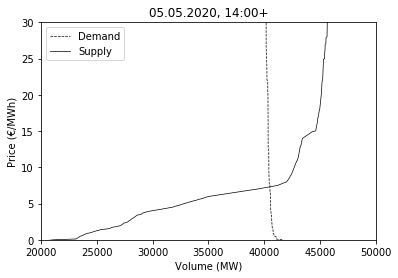

In [11]:
y_demand = df2['price'][df2['buy_sell']=="Buy curve"]
y_supply = df2['price'][df2['buy_sell']=="Sell curve"]

x_demand = df2['volume_adjusted'][df2['buy_sell']=="Buy curve"]
x_supply = df2['volume_adjusted'][df2['buy_sell']=="Sell curve"]

demand = plt.plot(x_demand, y_demand, 'k--', label= "Demand", linewidth=0.7)
supply = plt.plot(x_supply, y_supply, 'k-', label= "Supply", linewidth=0.7)
plt.ylabel('Price (€/MWh)')
plt.xlabel('Volume (MW)')
plt.ylim((0, 30))
plt.xlim((20000,50000))
#plt.axhline(y=0, color='r', linestyle='-')
title = str(date) + ", " + str(hour) + ":00+"
plt.title(title)
plt.legend()

date = date.replace(".","_")
outfile = figuresDir + "/Figure_" + str(date) + "_hr" + str(hour) + ".pdf"
plt.savefig(outfile, bbox_inches='tight')

## Exporting data

In [12]:
outfile = cleanDir + "/Data_" + str(date) + "_hr" + str(hour) + ".xlsx"
df2.to_excel(outfile, index=False)